In [2]:
import sys
sys.path.insert(0, 'C:\\Users\\kelvi\\mustafa\\artificial-intelligence-for-trading')

In [3]:
sys.executable

'c:\\Users\\kelvi\\anaconda\\envs\\AIND\\python.exe'

# Exploratory Data Analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,5)

In [5]:
data = pd.read_csv('eod-quotemedia.csv', parse_dates=['date'], index_col=False)
data.head()

,date,ticker,adj_close
0,2013-07-01,A,29.994186
1,2013-07-02,A,29.650137
2,2013-07-03,A,29.705185
3,2013-07-05,A,30.434568
4,2013-07-08,A,30.524021


Represent data in 3D

In [6]:
data.index

RangeIndex(start=0, stop=490737, step=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490737 entries, 0 to 490736
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       490737 non-null  datetime64[ns]
 1   ticker     490737 non-null  object        
 2   adj_close  490737 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.2+ MB


In [8]:
data3d = data.reset_index().pivot(index='date', columns='ticker', values='adj_close')

In [9]:
data3d.index

DatetimeIndex(['2013-07-01', '2013-07-02', '2013-07-03', '2013-07-05',
               '2013-07-08', '2013-07-09', '2013-07-10', '2013-07-11',
               '2013-07-12', '2013-07-15',
               ...
               '2017-06-19', '2017-06-20', '2017-06-21', '2017-06-22',
               '2017-06-23', '2017-06-26', '2017-06-27', '2017-06-28',
               '2017-06-29', '2017-06-30'],
              dtype='datetime64[ns]', name='date', length=1009, freq=None)

In [10]:
data3d.iloc[:3, :5]

ticker,A,AAL,AAP,AAPL,ABBV
date,,,,,
2013-07-01,29.994186,16.176093,81.138217,53.109173,34.924478
2013-07-02,29.650137,15.819834,80.722073,54.312247,35.428076
2013-07-03,29.705185,16.127950,81.237299,54.612043,35.444862


Resample data to Month End
* Using resample needs the index to be a datetime index.
* The `Resample()` function will group data into monthly buckets.
* We can't use `OHLC` function since our data only contains adjusted closing prices. Therefore we'll use `last()` function to get the last observation of each month.

In [11]:
resampled_data = data3d.resample('ME').last()

In [12]:
resampled_data.iloc[:5, :3]

ticker,A,AAL,AAP
date,,,
2013-07-31,30.778617,18.631393,81.732709
2013-08-31,32.092884,15.559861,79.334925
2013-09-30,35.346979,18.255876,81.982130
2013-10-31,35.009028,21.154093,98.342860
2013-11-30,36.947077,22.608016,100.157413


In [13]:
resampled_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2013-07-31 to 2017-06-30
Freq: ME
Columns: 495 entries, A to ZTS
dtypes: float64(495)
memory usage: 186.0 KB


In [14]:
apple_ticker = 'AAPL'
# resampled_data.loc[:, apple_ticker]
resampled_data[apple_ticker].head(10)

date
2013-07-31    58.730009
2013-08-31    63.649943
2013-09-30    62.282664
2013-10-31    68.285838
2013-11-30    73.070375
2013-12-31    73.720829
2014-01-31    65.781340
2014-02-28    69.562086
2014-03-31    70.950049
2014-04-30    78.002226
Freq: ME, Name: AAPL, dtype: float64

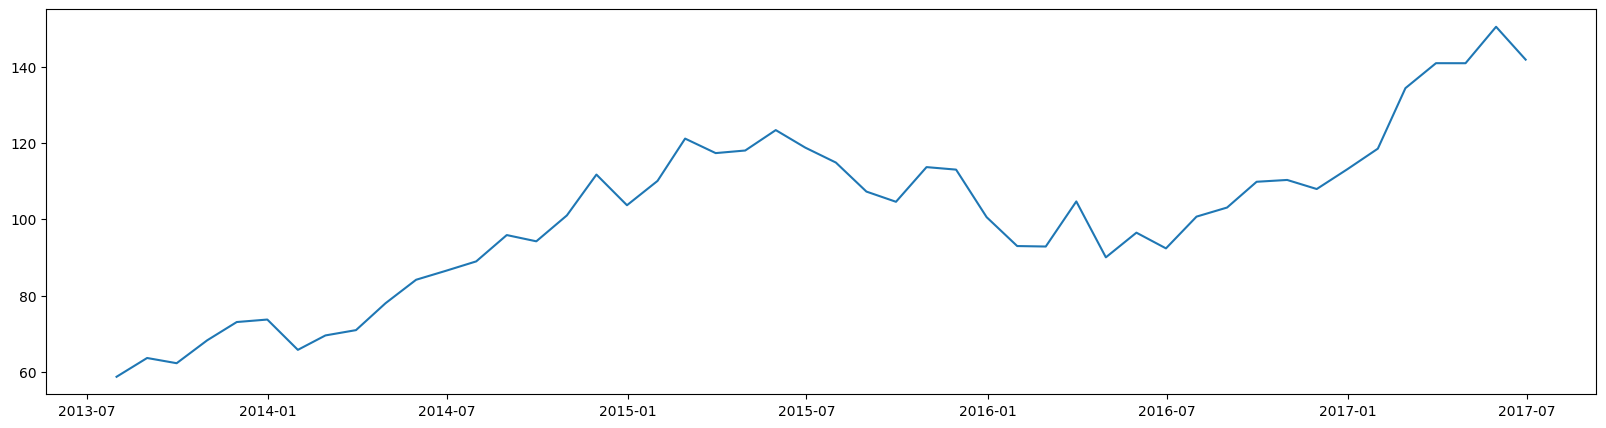

In [15]:
plt.plot(resampled_data.loc[:, apple_ticker])

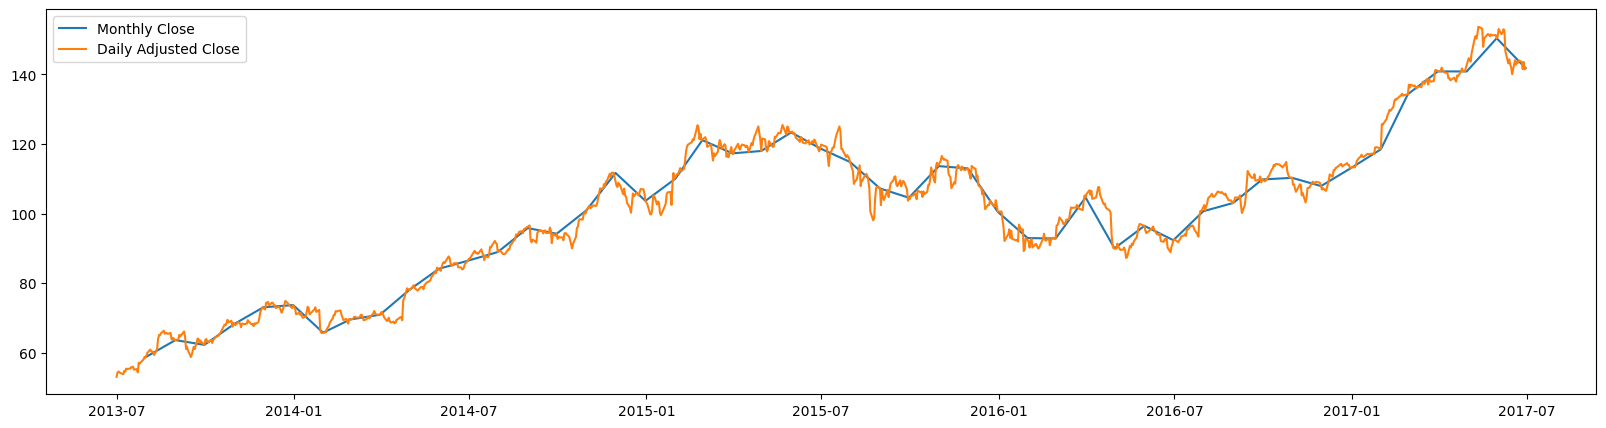

In [16]:
plt.plot(resampled_data.loc[:, apple_ticker], label='Monthly Close')
plt.plot(data3d.loc[:, apple_ticker], label='Daily Adjusted Close')
plt.legend()

# Creating Interactive charts using `Plotly`

In [17]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as offline_mode

offline_mode.init_notebook_mode(connected=True)

In [18]:
resampled_data.columns

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       ...
       'XL', 'XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS'],
      dtype='object', name='ticker', length=495)

In [19]:
def plot_stock(name, df):   
    return px.line(title=name, x=df.index, y=df )

In [20]:
# px.scatter(x=resampled_data.loc[:, apple_ticker].index, y=resampled_data.loc[:, apple_ticker])
plot_stock('Monthly close', resampled_data.loc[:, apple_ticker])

In [21]:
fig = px.line(title='{} close'.format(apple_ticker), x=resampled_data.loc[:, apple_ticker].index, y=resampled_data.loc[:, apple_ticker])
fig.add_scatter(x=data3d.loc[:, apple_ticker].index, y=data3d.loc[:, apple_ticker])
fig.show()

In [22]:
def _generate_traces(name_df):
    traces = []

    for name,df in name_df:
        traces.append(go.Scatter(
            name=name,
            x = df.index,
            y = df,
            mode = 'lines'
        ))
    return traces
    

In [23]:
traces = _generate_traces([('Monthly close',resampled_data.loc[:, apple_ticker]), ('Adjusted Daily close',data3d.loc[:, apple_ticker])])
offline_mode.iplot({"data":traces, 'layout':go.Layout(title="{} close".format(apple_ticker))})

# Calculate Returns

In [24]:
def calc_raw_returns(df, n_shift=1):
    # current price divided by previous price. Then minus 1 from the result.
    stock_returns = (df / df.shift(n_shift)) -1
    return stock_returns

In [25]:
raw_returns = calc_raw_returns(resampled_data)

In [26]:
plot_stock('{} raw_returns'.format(apple_ticker), raw_returns.loc[:,apple_ticker])

In [27]:
def calc_log_returns(df, nshift=1):
    """
    $$R_t = log_e(P_t) - log_e(P_{t-1})$$
    """
    # log of loookahead price minus log of current price
    log_returns = np.log(df) - np.log(df.shift(nshift))
    return log_returns

In [28]:
log_returns = calc_log_returns(resampled_data)

In [29]:
plot_stock('{} log_returns'.format(apple_ticker), log_returns.loc[:,apple_ticker])

In [30]:
prev_returns = log_returns.shift(1)
lookahead_returns = log_returns.shift(-1)

In [31]:
traces = _generate_traces([('previous log returns',prev_returns.loc[:, apple_ticker]), ('current log returns',log_returns.loc[:, apple_ticker])])
offline_mode.iplot({"data":traces, 'layout':go.Layout(title="{} previous vs current log returns".format(apple_ticker))})

In [32]:
traces = _generate_traces([('current log returns',log_returns.loc[:, apple_ticker]), ('lookahead log returns',lookahead_returns.loc[:, apple_ticker])])
offline_mode.iplot({"data":traces, 'layout':go.Layout(title="{} current vs lookahead log returns".format(apple_ticker))})

### Generate a Trading Signal

Produce long ("buy") and short ("sell") positions.

Select the top performing stocks for the long portfolio, and the bottom performing stocks for the short portfolio.

Implement the `get_top_n` function to get the top performing stocks for each month. Get the top performing stocks from `prev_returns` by assigning them a value of 1. For all other stocks, give them a value of 0.

In [33]:
def get_top_n(df, n):
    top_stock = df.copy()

    # for index, series in df.iterrows():
    #     top_stock.loc[index, series.index] = series.isin(df.loc[index, series.nlargest(n).index])
        
    return (top_stock.rank(1,method='average', numeric_only=False, na_option='keep', ascending=False) <= n).astype(np.int64)

In [34]:
sig = get_top_n(log_returns, 50)
sig

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-07-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2013-10-31,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-11-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2013-12-31,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2014-03-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
it = log_returns.iterrows()
next(it)

(Timestamp('2013-07-31 00:00:00'),
 ticker
 A      NaN
 AAL    NaN
 AAP    NaN
 AAPL   NaN
 ABBV   NaN
         ..
 XYL    NaN
 YUM    NaN
 ZBH    NaN
 ZION   NaN
 ZTS    NaN
 Name: 2013-07-31 00:00:00, Length: 495, dtype: float64)

In [36]:
next(it)

(Timestamp('2013-08-31 00:00:00'),
 ticker
 A       0.041814
 AAL    -0.180153
 AAP    -0.029776
 AAPL    0.080448
 ABBV   -0.065184
           ...   
 XYL    -0.001349
 YUM    -0.040582
 ZBH    -0.054021
 ZION   -0.056639
 ZTS    -0.022389
 Name: 2013-08-31 00:00:00, Length: 495, dtype: float64)

In [37]:
import itertools

In [38]:
for index, series in itertools.islice(sig.iterrows(), 48):
    print(f'index: {index} ====> {series.isnull().sum()}')

index: 2013-07-31 00:00:00 ====> 0
index: 2013-08-31 00:00:00 ====> 0
index: 2013-09-30 00:00:00 ====> 0
index: 2013-10-31 00:00:00 ====> 0
index: 2013-11-30 00:00:00 ====> 0
index: 2013-12-31 00:00:00 ====> 0
index: 2014-01-31 00:00:00 ====> 0
index: 2014-02-28 00:00:00 ====> 0
index: 2014-03-31 00:00:00 ====> 0
index: 2014-04-30 00:00:00 ====> 0
index: 2014-05-31 00:00:00 ====> 0
index: 2014-06-30 00:00:00 ====> 0
index: 2014-07-31 00:00:00 ====> 0
index: 2014-08-31 00:00:00 ====> 0
index: 2014-09-30 00:00:00 ====> 0
index: 2014-10-31 00:00:00 ====> 0
index: 2014-11-30 00:00:00 ====> 0
index: 2014-12-31 00:00:00 ====> 0
index: 2015-01-31 00:00:00 ====> 0
index: 2015-02-28 00:00:00 ====> 0
index: 2015-03-31 00:00:00 ====> 0
index: 2015-04-30 00:00:00 ====> 0
index: 2015-05-31 00:00:00 ====> 0
index: 2015-06-30 00:00:00 ====> 0
index: 2015-07-31 00:00:00 ====> 0
index: 2015-08-31 00:00:00 ====> 0
index: 2015-09-30 00:00:00 ====> 0
index: 2015-10-31 00:00:00 ====> 0
index: 2015-11-30 00

view Data

In [39]:
# print top tickers
sig.sum().sort_values()

ticker
ECL      0
VRSK     0
TROW     0
DXC      0
HON      0
        ..
NFLX    15
SWKS    15
AVGO    16
INCY    18
AMD     18
Length: 495, dtype: int64

In [40]:
sig.sum().sort_values(ascending=False).index[:5].values.tolist()

['INCY', 'AMD', 'AVGO', 'SWKS', 'NFLX']

In [41]:
def print_top_N(df, title, top_n):
    print('{} Most {}'.format(top_n,title), sep='\n')
    print(" , ".join(df.sum().sort_values(ascending=False).index[:top_n].values.tolist()), end='\n')

In [42]:
long_stocks = get_top_n(log_returns,50)
short_stocks = get_top_n(-1*log_returns,50)
print_top_N(long_stocks, 'Longed stocks', 10)
print_top_N(short_stocks, 'Shorted stocks', 10)

10 Most Longed stocks
INCY , AMD , AVGO , SWKS , NFLX , NFX , ILMN , MU , UAL , CNC
10 Most Shorted stocks
FCX , CHK , MRO , RRC , FTI , GPS , MAT , DVN , WYNN , TRIP


# Trading Strategy
NB: Avoid survivorship bias (when testing your strategy, use dataset that contains companies that were part of the stock universe at that time.)

Momentum-based Portfolio.

Assumptions
* Each stock has the same number of dollars invested, so that the portfolio weights for each stock are the same.
* Both the long and short portfolio have the same dollar amount invested (in terms of absolute magnitude), in which case the combination of the long and short portfolios would also be the simple average between the two. where the short is a negative value.
$$(long + short)/2$$

Portfolio Returns

In [43]:
def portfolio_returns(df_long, df_short, lookahead_returns, n_stocks):
    portfolio_returns = ((df_long + (-1*df_short)) * lookahead_returns)/n_stocks
    return portfolio_returns

In [44]:
expected_portfolio_returns = portfolio_returns(long_stocks, short_stocks, lookahead_returns, 50)

In [45]:
expected_portfolio_returns.T.sum()

date
2013-07-31    0.000000
2013-08-31    0.017661
2013-09-30   -0.004509
2013-10-31    0.008482
2013-11-30    0.010167
2013-12-31    0.014841
2014-01-31   -0.006265
2014-02-28   -0.026242
2014-03-31    0.007980
2014-04-30   -0.021839
2014-05-31    0.018628
2014-06-30   -0.032104
2014-07-31   -0.031715
2014-08-31    0.010619
2014-09-30    0.000854
2014-10-31    0.074988
2014-11-30    0.021261
2014-12-31    0.017099
2015-01-31   -0.073090
2015-02-28   -0.001584
2015-03-31   -0.072506
2015-04-30   -0.041901
2015-05-31    0.044403
2015-06-30    0.024169
2015-07-31    0.012900
2015-08-31    0.025630
2015-09-30   -0.034940
2015-10-31   -0.014224
2015-11-30    0.017144
2015-12-31    0.036877
2016-01-31   -0.000727
2016-02-29   -0.051824
2016-03-31    0.043893
2016-04-30    0.000483
2016-05-31   -0.012331
2016-06-30   -0.072296
2016-07-31    0.000883
2016-08-31    0.017222
2016-09-30   -0.009480
2016-10-31    0.001372
2016-11-30   -0.002631
2016-12-31   -0.014689
2017-01-31    0.000384
2017-0

In [46]:
plot_stock('Portfolio Returns', expected_portfolio_returns.T.sum())

# Statistical Tests